In [1]:
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

ModuleNotFoundError: No module named 'numpy'

In [19]:
def generate_smiley(points, noise_factor=0.025):
    face_circle = np.array([[np.cos(theta), np.sin(theta)] for theta in np.linspace(0, 2 * np.pi, points)])[:-1].copy()
    left_eye = np.array([[0.3 * np.cos(theta) - 0.37, 0.3 * np.sin(theta) + 0.37] for theta in np.linspace(0, 2 * np.pi, points)])[:-1].copy()
    right_eye = np.array([[0.3 * np.cos(theta) + 0.37, 0.3 * np.sin(theta) + 0.37] for theta in np.linspace(0, 2 * np.pi, points)])[:-1].copy()
    smile = np.array([[0.8 * np.cos(theta), 0.4 * np.sin(theta) - 0.5] for theta in np.linspace(0.4 * np.pi, 0.6 * np.pi, points)])
    
    # Add noise to the coordinates
    noise = np.random.normal(scale=noise_factor, size=(len(face_circle), 2))
    face_circle += noise
    noise = np.random.normal(scale=noise_factor, size=(len(left_eye), 2))
    left_eye += noise
    noise = np.random.normal(scale=noise_factor, size=(len(right_eye), 2))
    right_eye += noise
    noise = np.random.normal(scale=noise_factor, size=(len(smile), 2))
    smile += noise
    
    return np.concatenate([face_circle, left_eye, right_eye, smile])

In [25]:
def plot_points(points):
    #plt.figure(figsize=(6, 6))
    plt.scatter(points[:, 0], points[:, 1], s=5, c='blue')
    plt.title('Point dataset')
    plt.show()

def delaunay_triangulation(points):
    tri = Delaunay(points)
    plt.triplot(points[:,0], points[:,1], tri.simplices)
    #plt.plot(points[:,0], points[:,1], 'o')
    plt.title('Delaunay Graph')
    plt.show()

def rdg_compute(points):
    # Create a Delaunay triangulation
    tri = Delaunay(points)
    result_edge_map = {}

    all_distances = []

    # Calculate minimum distances between each point and its neighbors
    for i, point in enumerate(points):
        # Find the indices of neighboring vertices for the current point
        simplex_indices = np.where(np.any(tri.simplices == i, axis=1))[0]
        neighbor_indices = np.unique(tri.simplices[simplex_indices])
        neighbors = points[neighbor_indices]

        distances = np.linalg.norm(neighbors - point, axis=1)
        min_distance = np.min(distances[distances > 0])  # Avoid zero distances

        all_distances.extend(distances[distances > 0])

        # Calculate distances between neighboring vertices
        for neighbor, distance in zip(neighbors, distances):
            if distance > 0:
                ratio = distance / min_distance
                result = np.sqrt(ratio * (distance / min_distance))  # Geometric average of ratios
                edge = tuple(sorted((tuple(point), tuple(neighbor)), key=lambda x: (x[0], x[1])))
                result_edge_map[edge] = result

    '''
    Attempt at calculating a dynamic threshold for the results as the average of all of them
    total_sum = 0
    count = 0
    for value in result_edge_map.values():
        if isinstance(value, (int, float)):
            total_sum += value
            count += 1
    #if count == 0:
     #   return 0  # To avoid division by zero
    threshold = total_sum / count
    print(f"Dynamic computed threshold: {threshold}")
    '''
    threshold = 2.5#np.median(all_distances) #2.5
    result_edge_map = {key: value for key, value in result_edge_map.items() if not (isinstance(value, (int, float)) and value > threshold)}
    
    for edge, result in result_edge_map.items():
        #print(f"Edge: {edge} -> Result: {result}")
        edge_array = np.array(edge)
        plt.plot(edge_array[:, 0], edge_array[:, 1], color='blue')

    # Plot the original points
    #plt.scatter(points[:, 0], points[:, 1], color='blue')
    plt.title('Reduced Delaunay Graph')
    plt.show()

def kmeans_clustering(points, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(points)

    # Create a mesh grid to plot the decision boundaries
    x_min, x_max = points[:, 0].min() - 1, points[:, 0].max() + 1
    y_min, y_max = points[:, 1].min() - 1, points[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                        np.arange(y_min, y_max, 0.02))

    # Predict clusters for each point in the mesh grid
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot the decision boundaries
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(points[:, 0], points[:, 1], c=kmeans.labels_, s=25, cmap='viridis', edgecolors='k')
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=10, alpha=0.9, marker='X')
    plt.title('K-means Clustering')
    plt.show()

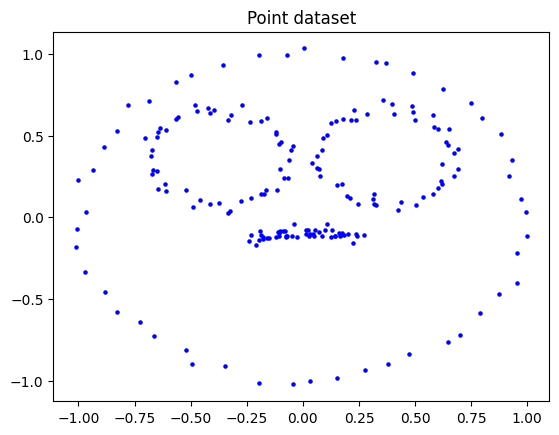

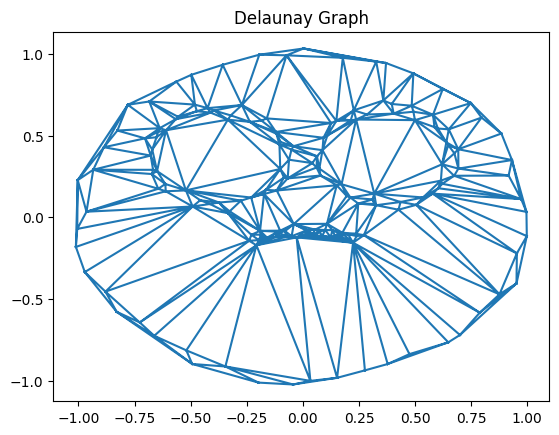

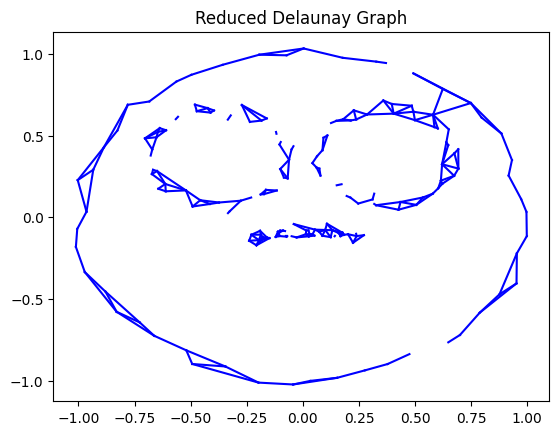

C:\Users\Matteo\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


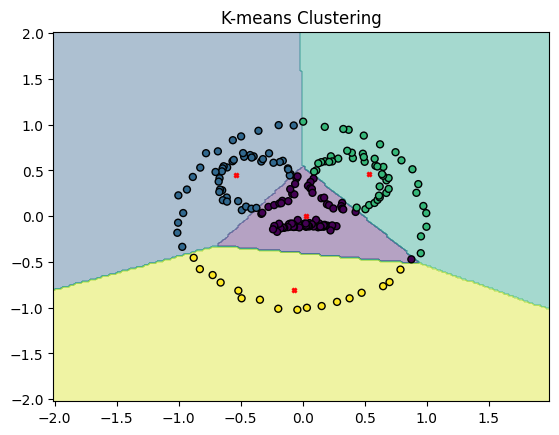

In [26]:
# Example array of points
#points = np.array([[-1, -1], [-1, -0.75], [-0.75, -0.75], [-0.75, -1], [1, 1], [1, 0.75], [0.75, 0.75], [0.75, 1], [-1, 1], [-1, 0.75], [-0.75, 0.75], [-0.75, 1], [1, -1], [1, -0.75], [0.75, -0.75], [0.75, -1]])
points = generate_smiley(50)

plot_points(points)
delaunay_triangulation(points)
rdg_compute(points)
kmeans_clustering(points, 4)